# Conditional cell diffusion processes

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr

import matplotlib.pyplot as plt
from flax import nnx

from neuralbridge.sdes.examples import CellSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedBridgeSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import train, load

In [2]:
rngs = nnx.Rngs(42)

In [3]:
x0 = jnp.array([0.1, -0.1])
v  = jnp.array([2.0, 0.1])
epsilon = 1e-5

N_steps = 400
T = 4.0
ts = jnp.linspace(0, T, N_steps + 1, endpoint=True)

sde = CellSDE(
    params={
        "sigma": 0.1 * jnp.eye(2)
    }
)
aux_sde = AuxiliarySDE(
    dim=2,
    coeffs={
        "T": T,
        "beta": lambda t: jnp.ones((2,)),
        "B": lambda t: -jnp.eye(2),
        "a_tilde_0": None,
        "a_tilde_T": 0.01 * jnp.eye(2),
    }
)

guided_sde = GuidedBridgeSDE(
    sde,
    aux_sde,
    obs_params={
        "vT": v,
        "LT": jnp.eye(2),
        "SigmaT": epsilon**2 * jnp.eye(2),
    },
    ts=ts,
    eq_type="uLM"
)

In [4]:
n_samples = 100

guided_sde_solver = SDESolver(
    sde=guided_sde,
    method="euler"
)
batch_guided_xs = guided_sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


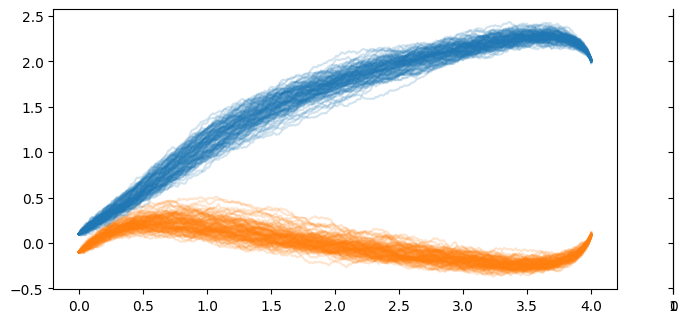

In [5]:
fig, axs = plt.subplot_mosaic([['.', '.'],
                               ["traj", "histy"]],
                              figsize=(8, 8),
                              width_ratios=[1, 0.0],
                              layout='constrained',
                              sharey=True)
guided_xT = batch_guided_xs[:, -1, :]
for i in range(100):
    axs["traj"].plot(ts, batch_guided_xs[i, :, 0], color="C0", alpha=0.2)
    axs["traj"].plot(ts, batch_guided_xs[i, :, 1], color="C1", alpha=0.2)

# axs["histy"].hist(guided_xT[:, 0], bins=50, color="C0", alpha=0.5, orientation='horizontal', density=True)
# axs["histy"].hist(guided_xT[:, 1], bins=50, color="C1", alpha=0.5, orientation='horizontal', density=True)
# grid = jnp.linspace(-0.5, 2.5, 500)
# pdfs1 = jsp.stats.norm.pdf(grid, loc=v[0], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[0]))
# pdfs2 = jsp.stats.norm.pdf(grid, loc=v[1], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[1]))
# axs["histy"].plot(pdfs1, grid, color='blue', alpha=0.5)
# axs["histy"].plot(pdfs2, grid, color='red', alpha=0.5)

In [6]:
sde_solver = SDESolver(
    sde=sde,
    method="milstein"
)
batch_xs = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

NameError: name 'obs_noise_cov' is not defined

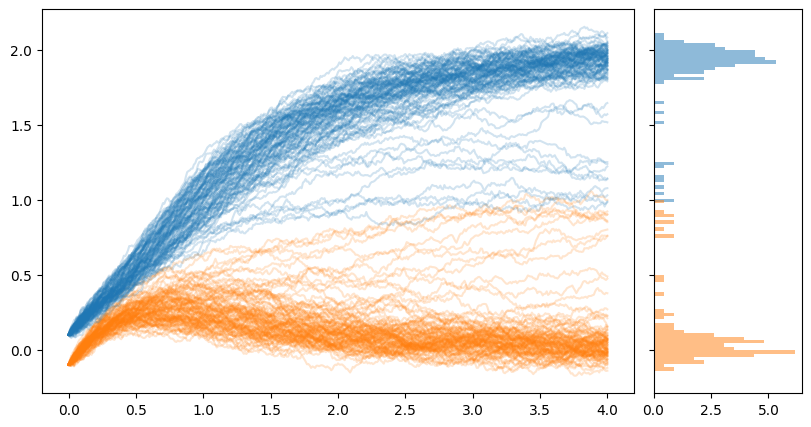

In [7]:
fig, axs = plt.subplot_mosaic([['.', '.'],
                               ["traj", "histy"]],
                              figsize=(8, 8),
                              width_ratios=[1, 0.25],
                              layout='constrained',
                              sharey=True)
xT = batch_xs[:, -1, :]
for i in range(100):
    axs["traj"].plot(ts, batch_xs[i, :, 0], color="C0", alpha=0.2)
    axs["traj"].plot(ts, batch_xs[i, :, 1], color="C1", alpha=0.2)

axs["histy"].hist(xT[:, 0], bins=50, color="C0", alpha=0.5, orientation='horizontal', density=True)
axs["histy"].hist(xT[:, 1], bins=50, color="C1", alpha=0.5, orientation='horizontal', density=True)
grid = jnp.linspace(-0.5, 2.5, 500)
pdfs1 = jsp.stats.norm.pdf(grid, loc=v[0], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[0]))
pdfs2 = jsp.stats.norm.pdf(grid, loc=v[1], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[1]))
axs["histy"].plot(pdfs1, grid, color='blue', alpha=0.5)
axs["histy"].plot(pdfs2, grid, color='red', alpha=0.5)

In [18]:
b_fn = guided_sde.b
sigma_fn = guided_sde.sigma
G_fn = guided_sde.G

nn_config = {
    "model_name": "MLPSmall",
    "input_dim": 2,
    "output_dim": 2,
    "hidden_dims": (20, 20, 20),
    "act_type": "lipswish",
    "rngs": rngs
}

neural_bridge = NeuralBridge(
    b_fn, sigma_fn, G_fn, nn_config
)

In [19]:
train_config = {
    "ckpt_dir": "../assets/ckpts/neural_bridge/cell",
    "lr": 1e-2,
    "batch_size": 32,
    "n_iters": 5000,
}
train(neural_bridge, x0, ts, train_config, rngs=rngs)

Step [  100 / 5000]: loss = -171.800964, Time: 1.519s
Step [  200 / 5000]: loss = -176.144791, Time: 0.844s
Step [  300 / 5000]: loss = -176.267761, Time: 0.845s
Step [  400 / 5000]: loss = -176.316269, Time: 0.842s
Step [  500 / 5000]: loss = -176.339371, Time: 0.846s
Step [  600 / 5000]: loss = -176.352890, Time: 0.875s
Step [  700 / 5000]: loss = -176.361938, Time: 0.845s
Step [  800 / 5000]: loss = -176.365631, Time: 0.854s
Step [  900 / 5000]: loss = -176.379532, Time: 0.848s
Step [ 1000 / 5000]: loss = -176.385590, Time: 0.844s
Step [ 1100 / 5000]: loss = -176.394348, Time: 0.845s
Step [ 1200 / 5000]: loss = -176.391525, Time: 0.841s
Step [ 1300 / 5000]: loss = -176.405960, Time: 0.849s
Step [ 1400 / 5000]: loss = -176.411987, Time: 0.853s
Step [ 1500 / 5000]: loss = -176.425034, Time: 0.867s
Step [ 1600 / 5000]: loss = -176.429840, Time: 0.850s
Step [ 1700 / 5000]: loss = -176.436401, Time: 0.846s
Step [ 1800 / 5000]: loss = -176.449402, Time: 0.846s
Step [ 1900 / 5000]: loss = 

In [14]:
nb_sde_solver = SDESolver(
    sde=neural_bridge,
    method="euler"
)
batch_nb_xs = nb_sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 10)

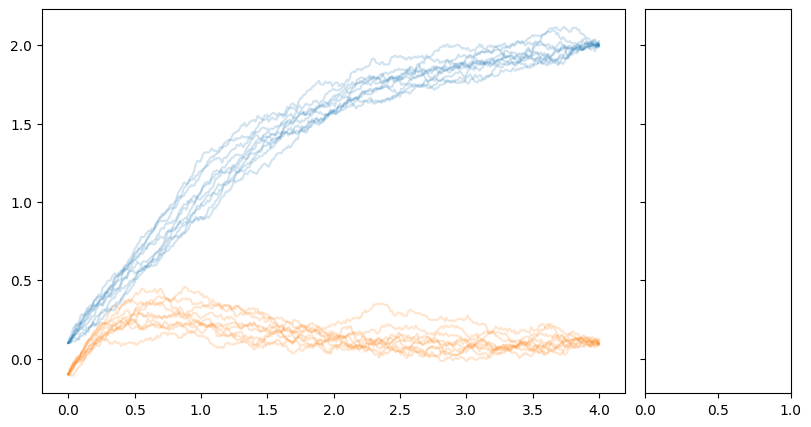

In [15]:
fig, axs = plt.subplot_mosaic([['.', '.'],
                               ["traj", "histy"]],
                              figsize=(8, 8),
                              width_ratios=[1, 0.25],
                              layout='constrained',
                              sharey=True)
nb_xT = batch_nb_xs[:, -1, :]
for i in range(10):
    axs["traj"].plot(ts, batch_nb_xs[i, :, 0], color="C0", alpha=0.2)
    axs["traj"].plot(ts, batch_nb_xs[i, :, 1], color="C1", alpha=0.2)

# axs["histy"].hist(nb_xT[:, 0], bins=50, color="C0", alpha=0.5, orientation='horizontal', density=True)
# axs["histy"].hist(nb_xT[:, 1], bins=50, color="C1", alpha=0.5, orientation='horizontal', density=True)
# grid = jnp.linspace(-0.5, 2.5, 500)
# pdfs1 = jsp.stats.norm.pdf(grid, loc=v[0], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[0]))
# pdfs2 = jsp.stats.norm.pdf(grid, loc=v[1], scale=jnp.sqrt(jnp.diag(obs_noise_cov)[1]))
# axs["histy"].plot(pdfs1, grid, color='blue', alpha=0.5)
# axs["histy"].plot(pdfs2, grid, color='red', alpha=0.5)